This script is to map the fire data w weather data

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
from scipy.spatial import cKDTree

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [5]:
# example to use geodesic()
from geopy.distance import geodesic

# Define the coordinates
coords_1 = (40.452058, -124.374975)
coords_2 = (40.41039, -124.374975)

# Calculate the distance
distance = geodesic(coords_1, coords_2).km

# Print the distance
print(f"Distance: {distance} km")

Distance: 4.626936837923472 km


In [6]:
pd.set_option('display.max_colwidth', None)

Clean fire data

In [11]:
# read calfire_2001_2023.shp
gdf = gpd.read_file('../Fire_Data/calfire_2001_2023.shp')

In [10]:
gdf.shape, gdf.dtypes

((7636, 20),
 YEAR_            int64
 STATE           object
 AGENCY          object
 UNIT_ID         object
 FIRE_NAME       object
 INC_NUM         object
 IRWINID         object
 ALARM_DATE      object
 CONT_DATE       object
 C_METHOD         int64
 CAUSE            int64
 OBJECTIVE        int64
 GIS_ACRES      float64
 COMPLEX_NA      object
 COMPLEX_ID      object
 COMMENTS        object
 FIRE_NUM        object
 Shape_Leng     float64
 Shape_Area     float64
 geometry      geometry
 dtype: object)

In [10]:
# Function to correct the date
def correct_date(row):
    year = str(row['YEAR_'])
    if row['ALARM_DATE'] and row['ALARM_DATE'].startswith('0'):
        row['ALARM_DATE'] = year + row['ALARM_DATE'][4:]
    if row['CONT_DATE'] and row['CONT_DATE'].startswith('0'):
        row['CONT_DATE'] = year + row['CONT_DATE'][4:]
    return row

In [12]:
# this step is removed bc when creating the label, there might be a fire event in that location in that year.
# to be accurate, we should keep the data for generating the label (remove that location during that year)
# Remove rows that have ALARM_DATE and CONT_DATE as NaT
# initial_rows = gdf.shape[0]
# gdf = gdf[~(gdf['ALARM_DATE'].isna() & gdf['CONT_DATE'].isna())]
# rows_after_removal = gdf.shape[0]
# print(f"Removed {initial_rows - rows_after_removal} rows with both ALARM_DATE and CONT_DATE as NaT")

# Print rows with ALARM_DATE starting with '0' before correction
rows_before_correction = gdf[gdf['ALARM_DATE'].astype(str).str.startswith('0')][['YEAR_', 'ALARM_DATE', 'CONT_DATE']]
indices_before_correction = rows_before_correction.index.tolist()
print("Rows with ALARM_DATE starting with '0' before correction:")
print(rows_before_correction)

# Apply the function to correct the dates
gdf = gdf.apply(correct_date, axis=1)
print("Corrected dates where ALARM_DATE or CONT_DATE started with '0'")

# Print the rows with the stored indices after correction
print("Rows with ALARM_DATE starting with '0' after correction:")
rows_after_correction = gdf.loc[indices_before_correction, ['YEAR_', 'ALARM_DATE', 'CONT_DATE']]
print(rows_after_correction)

# Check the current CRS of the GeoDataFrame
print(f"Current CRS: {gdf.crs}")

# If the CRS is not set or incorrect, set it
if gdf.crs is None or gdf.crs.to_string() != 'EPSG:3310':
    gdf = gdf.set_crs('EPSG:3310')
    print("Set CRS to EPSG:3310")

# Check for invalid geometries
# invalid_geometries = gdf[~gdf.is_valid]
# print(f"Invalid geometries: {len(invalid_geometries)}")

# Optionally, remove invalid geometries
# gdf = gdf[gdf.is_valid]

# gdf['geometry'] = gdf['geometry'].buffer(0)

# Transform the GeoDataFrame to WGS84 (EPSG:4326)
gdf_wgs84 = gdf.to_crs('EPSG:4326')
print("Transformed GeoDataFrame to WGS84 (EPSG:4326)")

# Filter out northern California
initial_rows = gdf_wgs84.shape[0]
gdf_wgs84 = gdf_wgs84[gdf_wgs84.geometry.centroid.y < 42]
rows_after_filter = gdf_wgs84.shape[0]
print(f"Removed {initial_rows - rows_after_filter} rows outside northern California")

# Print the final shape of the GeoDataFrame
print(f"Final shape of the GeoDataFrame: {gdf_wgs84.shape}")

Rows with ALARM_DATE starting with '0' before correction:
      YEAR_  ALARM_DATE   CONT_DATE
1662   2019  0219-05-29  0219-05-29
Corrected dates where ALARM_DATE or CONT_DATE started with '0'
Rows with ALARM_DATE starting with '0' after correction:
      YEAR_  ALARM_DATE   CONT_DATE
1662   2019  2019-05-29  2019-05-29
Current CRS: EPSG:3310
Transformed GeoDataFrame to WGS84 (EPSG:4326)
Removed 10 rows outside northern California
Final shape of the GeoDataFrame: (7626, 20)


C:\Users\fangshuye\AppData\Local\Temp\ipykernel_30732\2788290796.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs84 = gdf_wgs84[gdf_wgs84.geometry.centroid.y < 42]


In [13]:
# extract the centroid of gdf_wgs84 to a new column
gdf_wgs84['centroid'] = gdf_wgs84.centroid

C:\Users\fangshuye\AppData\Local\Temp\ipykernel_30732\1857600888.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_wgs84['centroid'] = gdf_wgs84.centroid


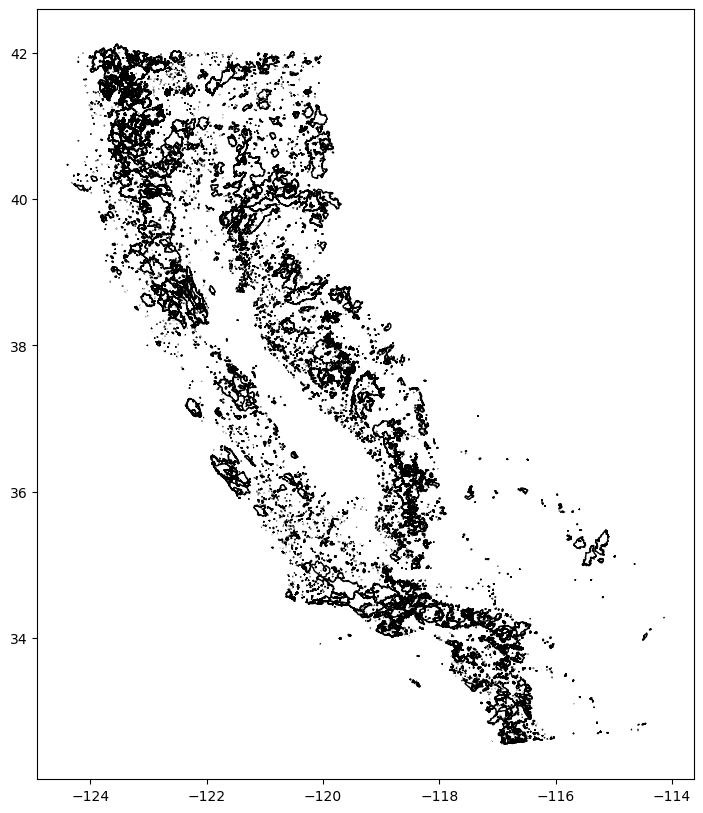

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_wgs84.boundary.plot(ax=ax, linewidth=1, color='black')
plt.show()

Clean weather data

In [15]:
files = os.listdir('../Weather_Data/')
files

['dead_fuel_moisture_1000hr.2001.2023.CA.nc',
 'dead_fuel_moisture_100hr.2001.2023.CA.nc',
 'expanded_Palmer_Drought_Severity_Index.2001.2023.CA.nc',
 'max_air_temperature.2001.2023.CA-008.nc',
 'max_relative_humidity.2001.2023.CA.nc',
 'max_wind_speed.2001.2023.CA.nc',
 'min_air_temperature.2001.2023.CA-009.nc',
 'min_relative_humidity.2001.2023.CA.nc',
 'Palmer_Drought_Severity_Index.2001.2023.CA.nc',
 'precipitation_amount.2001.2023.CA.nc',
 'specific_humidity.2001.2023.CA.nc',
 'surface_downwelling_shortwave_flux.2001.2023.CA.nc',
 'wind_from_direction.2001.2023.CA.nc',
 'wind_speed.2001.2023.CA.nc']

In [16]:
data_dir = '../Weather_Data/'
# Load the first dataset to use as a reference
reference_ds = xr.open_dataset(os.path.join(data_dir, files[0]))

In [17]:
print(f"Dimensions: {reference_ds.dims}")
print(f"Coordinates: {reference_ds.coords}")
print(f"Data variables: {reference_ds.data_vars}")

Dimensions: Frozen({'day': 8400, 'lon': 259, 'lat': 240})
Coordinates: Coordinates:
  * day      (day) datetime64[ns] 2001-01-01 2001-01-02 ... 2023-12-31
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -114.1 -114.1 -114.0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.15 32.11 32.07 32.03
Data variables: Data variables:
    dead_fuel_moisture_1000hr  (day, lat, lon) float32 ...


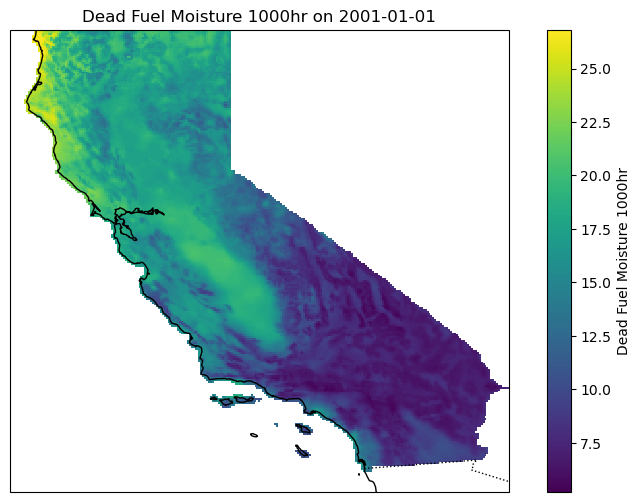

In [24]:
# check how sample data looks like in map

# extract data when day = "2001-01-01"
dead_fuel_2001 = reference_ds.sel(day="2001-01-01")

# Plot the data variable on a map
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([dead_fuel_2001.lon.min(), dead_fuel_2001.lon.max(), dead_fuel_2001.lat.min(), dead_fuel_2001.lat.max()], crs=ccrs.PlateCarree())

# Add coastlines and borders for context
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot the data variable
data = dead_fuel_2001['dead_fuel_moisture_1000hr']
data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', cbar_kwargs={'label': 'Dead Fuel Moisture 1000hr'})

# Add a title
plt.title('Dead Fuel Moisture 1000hr on 2001-01-01')

# Show the plot
plt.show()

In [18]:
# Create a meshgrid of lat and lon coordinates
lon, lat = np.meshgrid(reference_ds.lon.values, reference_ds.lat.values)

# Flatten the meshgrid arrays
lon_flat = lon.flatten()
lat_flat = lat.flatten()

# Create a KDTree for the reference_ds coordinates
tree = cKDTree(np.c_[lat_flat, lon_flat])

# Initialize lists to store the nearest coordinates
nearest_lons = []
nearest_lats = []
distances = []

# Iterate over the centroids
for centroid in tqdm(gdf_wgs84['centroid']):
    lon = centroid.x
    lat = centroid.y
    # Query the nearest neighbor using KDTree
    _, idx = tree.query([lat, lon], k=1)
    
    # Get the nearest reference point
    nearest_lat, nearest_lon = lat_flat[idx], lon_flat[idx]

    # Calculate the exact geodesic distance
    distance = geodesic((lat, lon), (nearest_lat, nearest_lon)).km
    
    # Append the nearest coordinates to the lists
    nearest_lons.append(nearest_lon)
    nearest_lats.append(nearest_lat)
    distances.append(distance)

# Add the nearest coordinates to the DataFrame
gdf_wgs84['lon'] = nearest_lons
gdf_wgs84['lat'] = nearest_lats
gdf_wgs84['distance'] = distances

100%|██████████| 7626/7626 [00:01<00:00, 4754.09it/s]


In [26]:
# show all columns except geometry
gdf_wgs84.drop(columns=['geometry']).head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,...,COMPLEX_NA,COMPLEX_ID,COMMENTS,FIRE_NUM,Shape_Leng,Shape_Area,centroid,lon,lat,distance
0,2023,CA,CDF,SKU,WHITWORTH,00004808,{7985848C-0AC2-4BA4-8F0E-29F778652E61},2023-06-17,2023-06-17,1,...,None,None,None,None,933.907127,23184.946763,POINT (-122.91208 41.53217),-122.891667,41.525000,1.881068
1,2023,CA,LRA,BTU,KAISER,00010225,{43EBCC88-B3AC-48EB-8EF5-417FE0939CCF},2023-06-02,2023-06-02,1,...,None,None,None,None,986.343353,55046.898792,POINT (-121.96284 39.83074),-121.975000,39.816667,1.877651
2,2023,CA,CDF,AEU,JACKSON,00017640,{B64E1355-BF1D-441A-95D0-BC1FBB93483B},2023-07-01,2023-07-02,1,...,None,None,None,None,2115.572740,112561.147688,POINT (-120.90469 38.29510),-120.891667,38.275000,2.505485
3,2023,CA,CDF,AEU,CARBON,00018821,{CB41DB0A-E4B1-489D-A4EA-738F2CD6DB3B},2023-07-11,2023-07-11,1,...,None,None,None,None,1994.866526,237794.210367,POINT (-120.98417 38.44197),-120.975000,38.441667,0.801679
4,2023,CA,CDF,AEU,LIBERTY,00018876,{F83F70A4-07A7-40B8-BD51-10CCC1C30D63},2023-07-11,2023-07-12,1,...,None,None,None,None,4008.305800,287241.810389,POINT (-120.99593 38.24722),-121.016667,38.233333,2.381886


In [19]:
# check the range of distance after mapping
gdf_wgs84['distance'].describe()

count    7626.000000
mean        1.603370
std         0.608061
min         0.012649
25%         1.172902
50%         1.657564
75%         2.065681
max         2.958446
Name: distance, dtype: float64

the max distance between weather data and fire data is 3 km

In [20]:
# drop column geometry and centroid for saving data in parquet format
gdf_wgs84.drop(columns=['geometry', 'centroid']).to_parquet('../Clean_Data/fire_data_map_weather_lon_lat.parquet')